In [1]:
%pip install pandas
%pip install scikit-learn
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 107.8/107.8 kB 1.6 MB/s eta 0:00:00
Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl (161 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from datetime import datetime
import matplotlib.pyplot as plt
import time

def featureExtraction(df):
    # We exclude the tag column for now due to the complexity, adding tag can significantly increase accuracy also compute time 
    df = df[['title', 'category_id', 'publish_time', 'views']].dropna()
    
    # Extract time features
    df['publish_hour'] = df['publish_time'].dt.hour
    df['publish_dayofweek'] = df['publish_time'].dt.dayofweek
    
    # Transform categorical data
    cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    category_features = cat_encoder.fit_transform(df[['category_id']])
    
    # We process the text content with TF-IDF vectorization
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    text_features = tfidf.fit_transform(df['title'])
    
    # Proccess numeric features
    num_features = df[['publish_hour', 'publish_dayofweek']].values
    scaler = StandardScaler()
    num_features_scaled = scaler.fit_transform(num_features)

    return category_features, text_features, num_features_scaled


In [ ]:
def trainModel(X, y, param_grid, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    svr = SVR()
    
    grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_svr = grid_search.best_estimator_
    
    # Predictions on log scale
    y_pred = best_svr.predict(X_test)
    return y_pred, y_test


def evalAndChart(y_test_log, y_pred_log, title):
    y_test = np.expm1(y_test_log)
    y_pred = np.expm1(y_pred_log)
    mse = mean_squared_error(y_test, y_pred)
    mse_log = mean_squared_error(y_test_log, y_pred_log)    
    r2 = r2_score(y_test, y_pred)
    r2_log = r2_score(y_test_log, y_pred_log)
    
    print("MSE:", mse)  
    print("MSE (log scale):", mse_log)
    print("R-squared:", r2)
    print("R-squared (log scale):", r2_log)
 
    residuals = y_test - y_pred
    
    # Log Scale Scatter Plot
    plt.figure(figsize=(14, 8))
    plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted / Actual", color="blue")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Views (num)", fontsize=11)
    plt.ylabel("Predicted Views", fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Log Scale Scatter Plot (" + title + ")", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # Distribution of Errors (Residuals)
    plt.figure(figsize=(14, 8))
    plt.hist(residuals, bins=30, color="purple", alpha=0.7, edgecolor="black", label="Residuals Distribution")
    plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Zero Error Line")
    plt.xlabel("Residuals (Error)", fontsize=12)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Distribution of Errors (" + title + ")", fontsize=13)
    plt.legend(fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def applyTruncatedSVD(text_features):
    svd = TruncatedSVD(n_components=400, random_state=42)   # I have find 400 is a good number for accuracy and performance
    return svd.fit_transform(text_features)

40949
MSE: 11042199497624.053
MSE (log scale): 0.4365677050218323
R-squared: 0.7207026556153603
R-squared (log scale): 0.8210729137432902


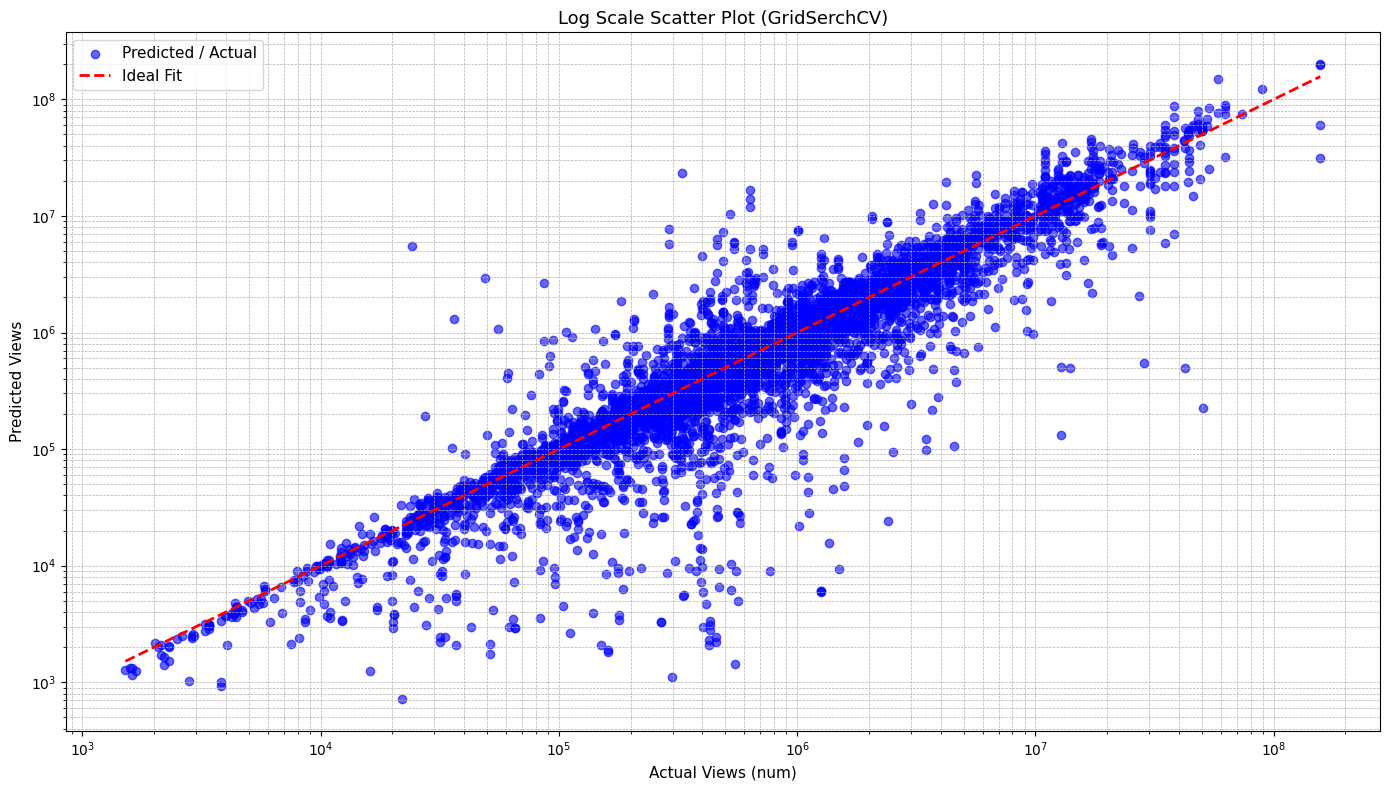

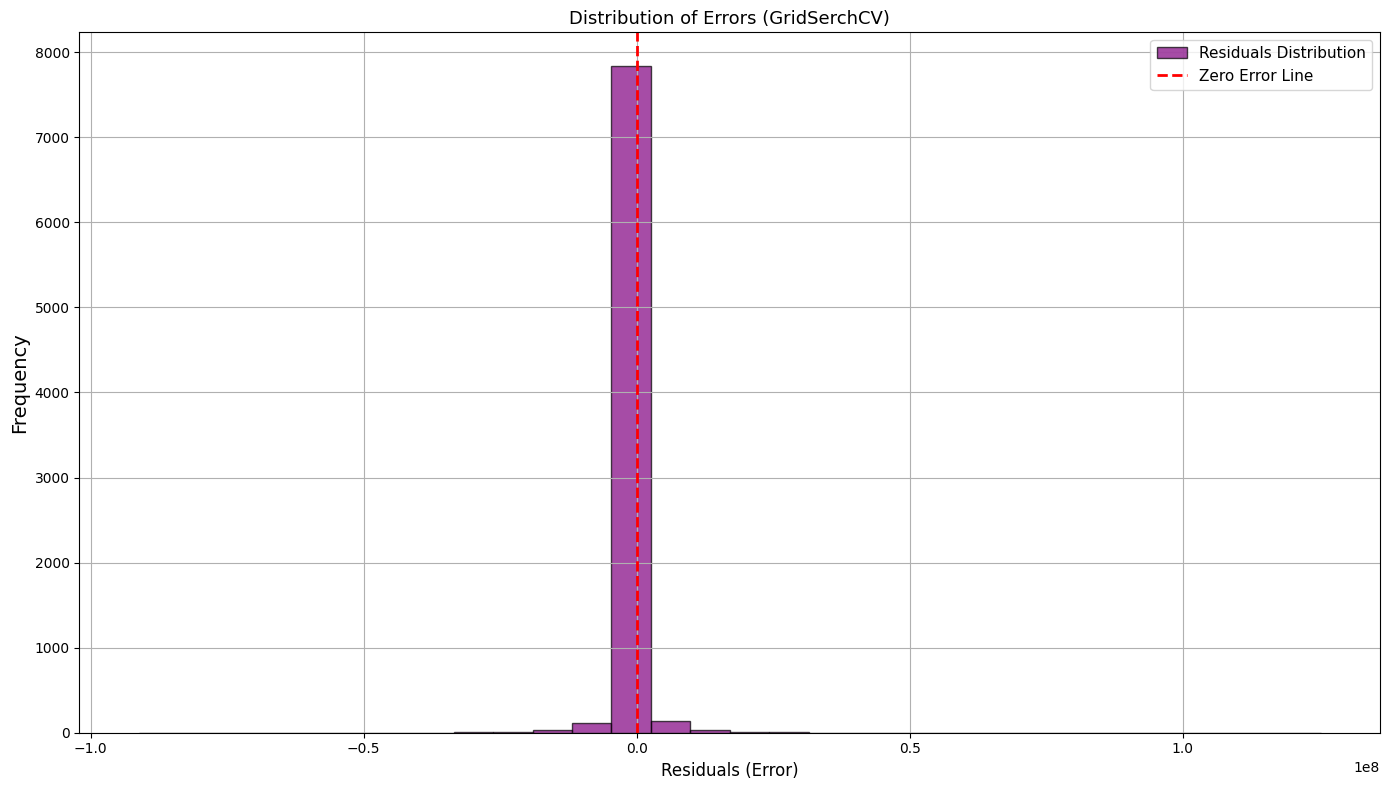

Processing time: 4519.2770 seconds


In [47]:
# Train and predict with GridSerchCV
df = pd.read_csv('USVideos.csv', parse_dates=['publish_time'])
print(len(df))

start_time = time.time()
category_features, text_features, num_features_scaled = featureExtraction(df)

X = np.hstack([text_features.toarray(), category_features, num_features_scaled])

# The distribution is highly skewed, the difference between data points can be up to several millions
y = np.log1p(df['views'].values)

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

y_pred, y_test = trainModel(X, y, param_grid)
evalAndChart(y_pred, y_test, "GridSerchCV")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processing time: {elapsed_time:.4f} seconds")

40949
MSE: 12786942336464.82
MSE (log scale): 0.5293999854867517
R-squared: 0.6535334570133957
R-squared (log scale): 0.7633663936051669


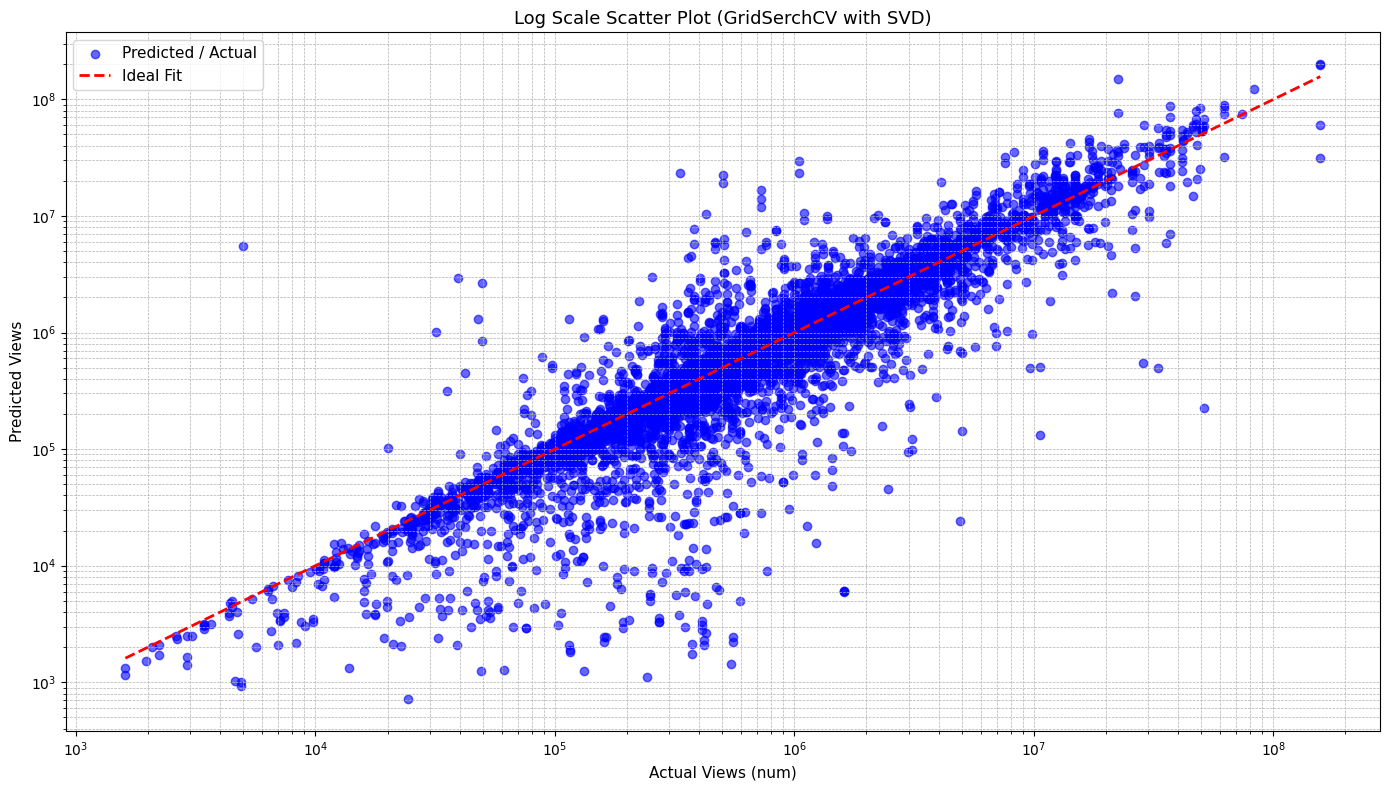

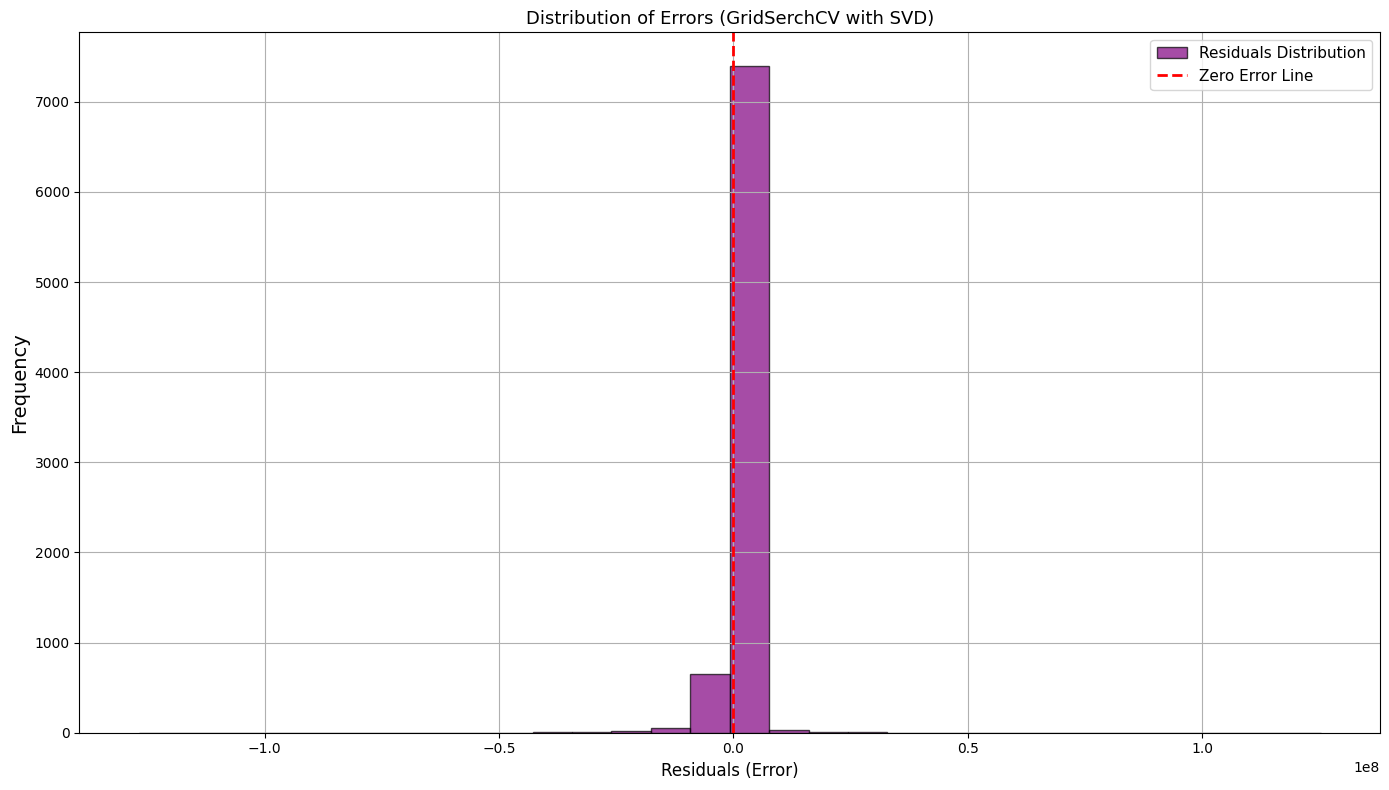

In [ ]:
# test SVD on GridSearchCV

df = pd.read_csv('USVideos.csv', parse_dates=['publish_time'])
print(len(df))

start_time = time.time()
category_features, text_features, num_features_scaled = featureExtraction(df)

text_features_svd = applyTruncatedSVD(text_features)
X = np.hstack([text_features_svd, category_features, num_features_scaled])

y = np.log1p(df['views'].values)
# Parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

y_pred, y_test = trainModel(X, y, param_grid)

evalAndChart(y_pred, y_test, "GridSerchCV with SVD")

40949
MSE: 33122914320649.945
MSE (log scale): 1.865165196458616
R-squared: -3.768220673689682
R-squared (log scale): -0.6088298042960598


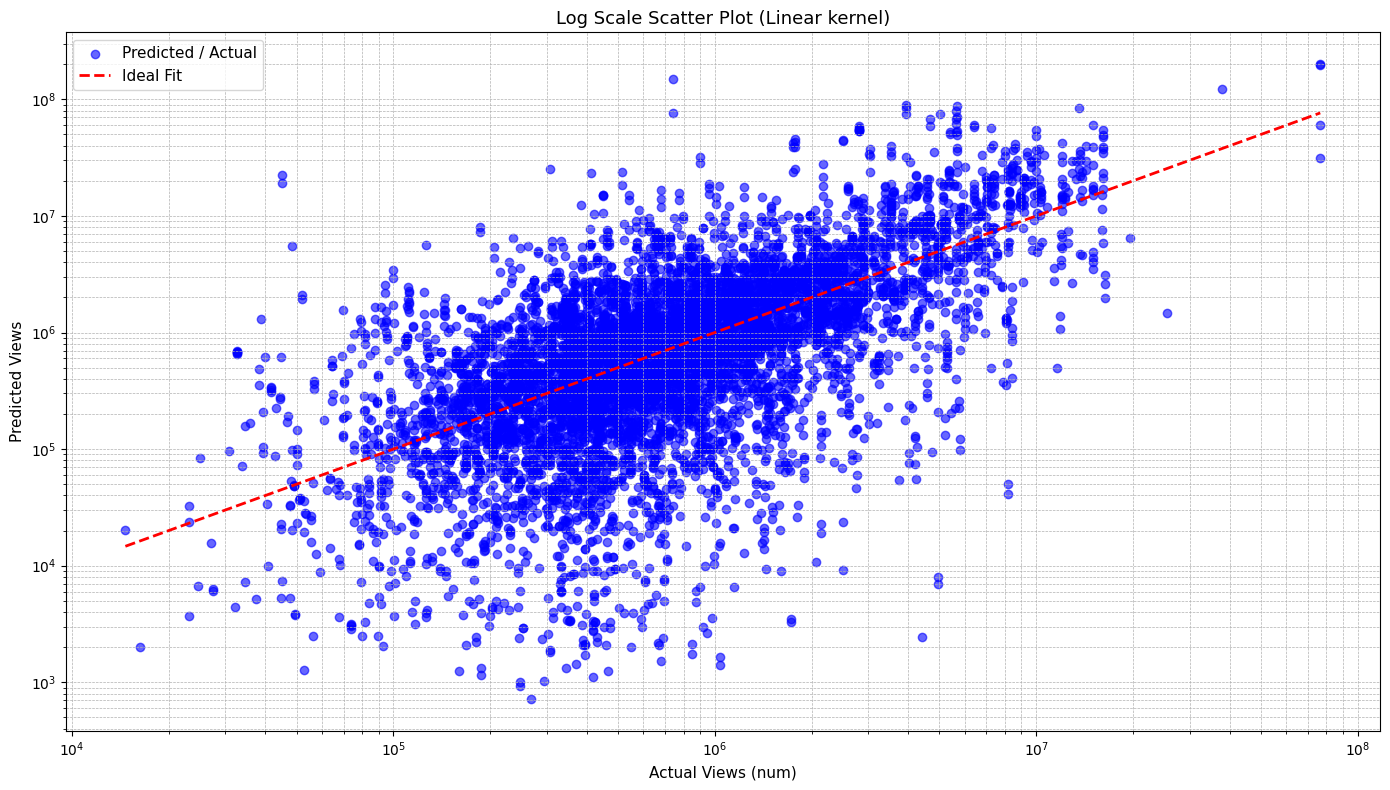

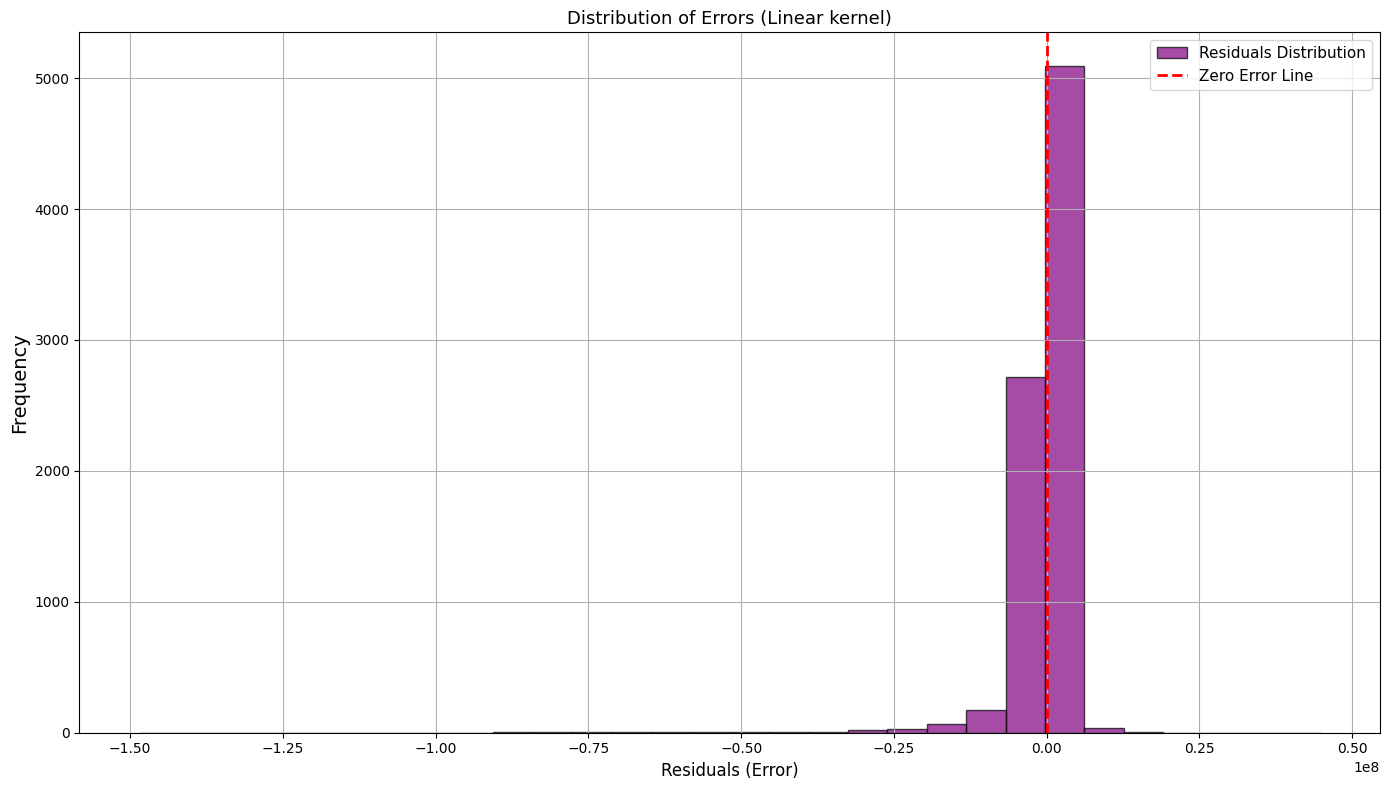

Processing time: 4247.6088 seconds


In [ ]:
# Use linear kernel
df = pd.read_csv('USVideos.csv', parse_dates=['publish_time'])
print(len(df))

start_time = time.time()
category_features, text_features, num_features_scaled = featureExtraction(df)
X = np.hstack([text_features.toarray(), category_features, num_features_scaled])

y = np.log1p(df['views'].values)
# Parameter grid for SVR
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}

y_pred, y_test = trainModel(X, y, param_grid)
evalAndChart(y_pred, y_test, "Linear kernel")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Processing time: {elapsed_time:.4f} seconds")

c:\Users\nuend\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, 'scale', 'rbf'] before, using random point [8.020297323103136, 0.4732705037968806, 'scale', 'rbf']
  warnings.warn(
c:\Users\nuend\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, 'scale', 'rbf'] before, using random point [3.069126698667837, 0.47704799367652195, 'auto', 'rbf']
  warnings.warn(
c:\Users\nuend\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, 'scale', 'rbf'] before, using random point [0.8116139286697238, 0.46402356203576217, 'auto', 'rbf']
  warnings.warn(
c:\Users\nuend\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The ob

MSE: 4531236694526.478
MSE (log scale): 0.5483699161576631
R-squared: 0.7754114702161821
R-squared (log scale): 0.7813936408600818


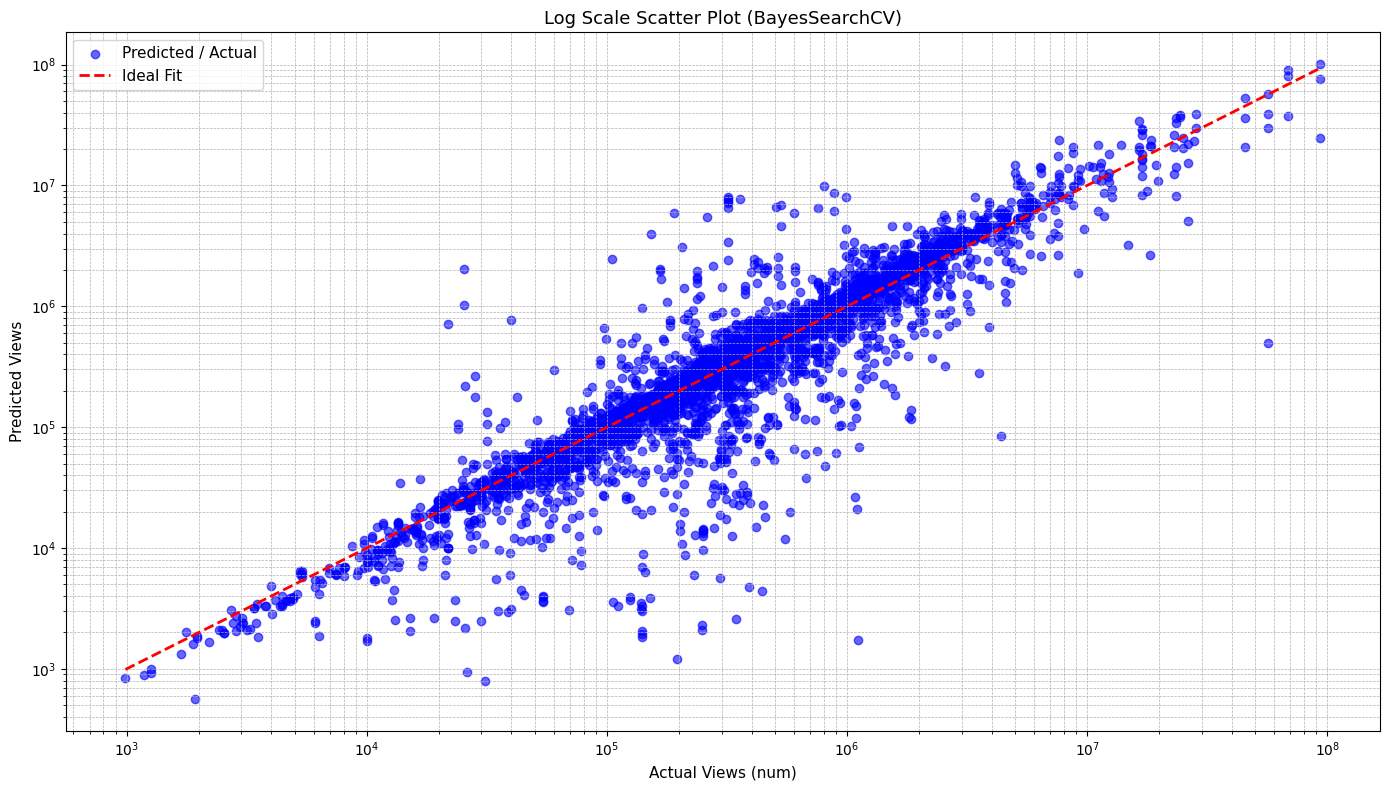

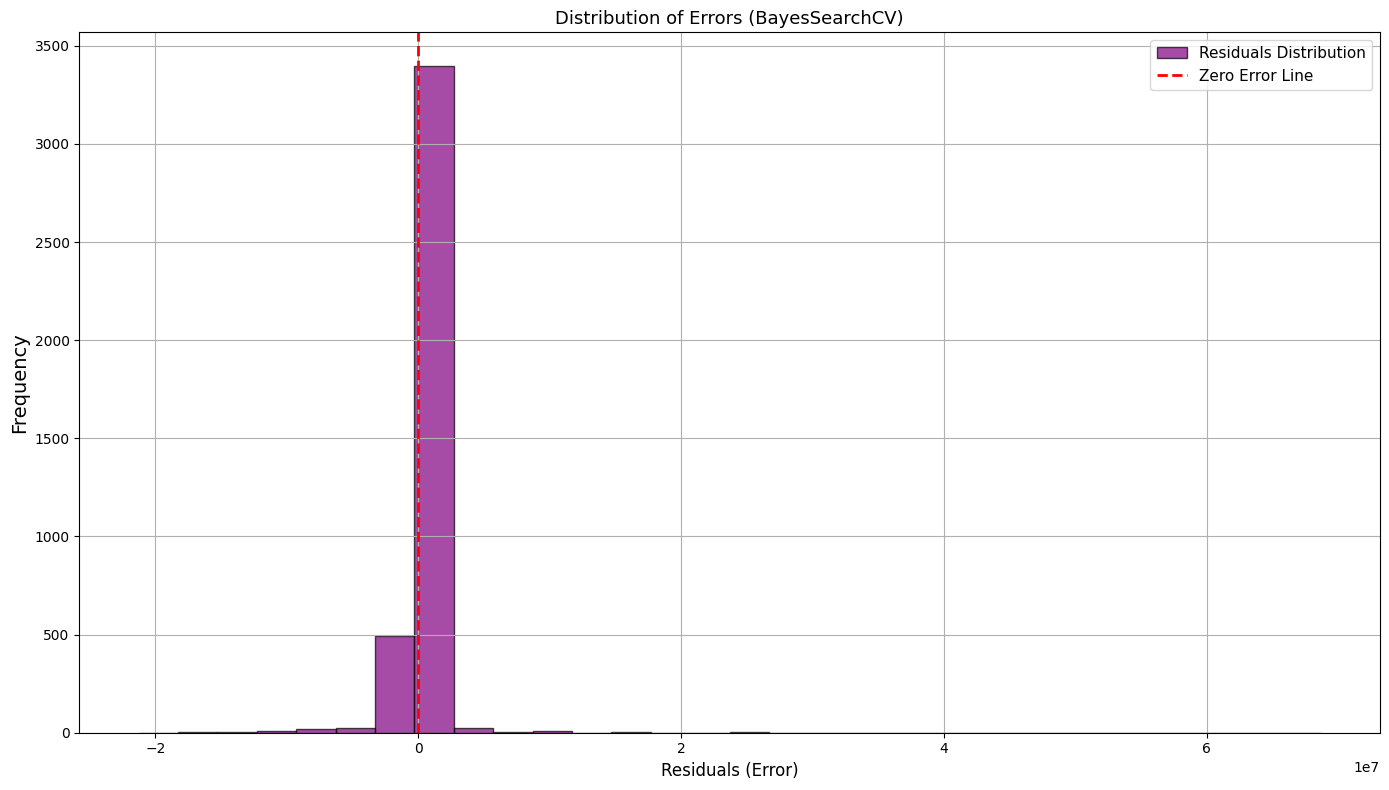

Processing time: 2481.0242 seconds


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
df = pd.read_csv('USVideos.csv', parse_dates=['publish_time'], nrows=30000)

def trainModelWithBayesSearch(X, y, search_spaces, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    svr = SVR()

    bayes_search = BayesSearchCV(
        svr, 
        search_spaces=search_spaces,
        n_iter=30,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)
    best_svr = bayes_search.best_estimator_

    # Predictions on log scale
    y_pred = best_svr.predict(X_test)
    return y_pred, y_test

category_features, text_features, num_features_scaled = featureExtraction(df)

X = np.hstack([text_features.toarray(), category_features, num_features_scaled])
y = np.log1p(df['views'].values)

search_spaces = {
    'C': Real(0.1, 10, prior='log-uniform'),  # Regularization parameter
    'epsilon': Real(0.01, 0.5, prior='uniform'),  # Tolerance margin
    'gamma': Categorical(['scale', 'auto']),  # Kernel coefficient
    'kernel': Categorical(['rbf'])
}
start_time = time.time()

y_pred, y_test = trainModelWithBayesSearch(X, y, search_spaces)

end_time = time.time()
elapsed_time = end_time - start_time

evalAndChart(y_pred, y_test, "BayesSearchCV")
print(f"Processing time: {elapsed_time:.4f} seconds")


c:\Users\nuend\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 0.01, 'scale', 'rbf'] before, using random point [8.020297323103136, 0.4732705037968806, 'scale', 'rbf']
  warnings.warn(


MSE: 10827029356246.127
MSE (log scale): 0.43509802912178425
R-squared: 0.7172408027122376
R-squared (log scale): 0.8195984892287541


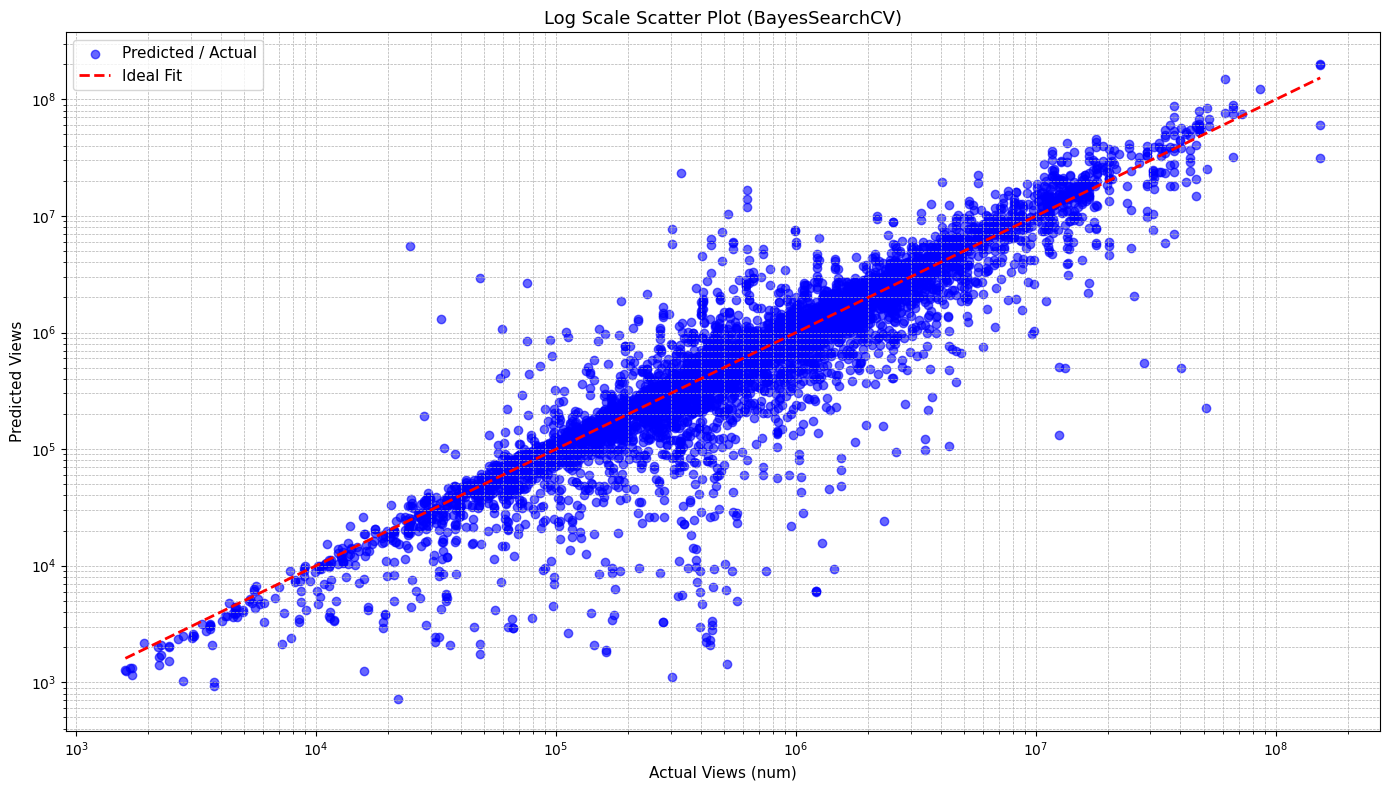

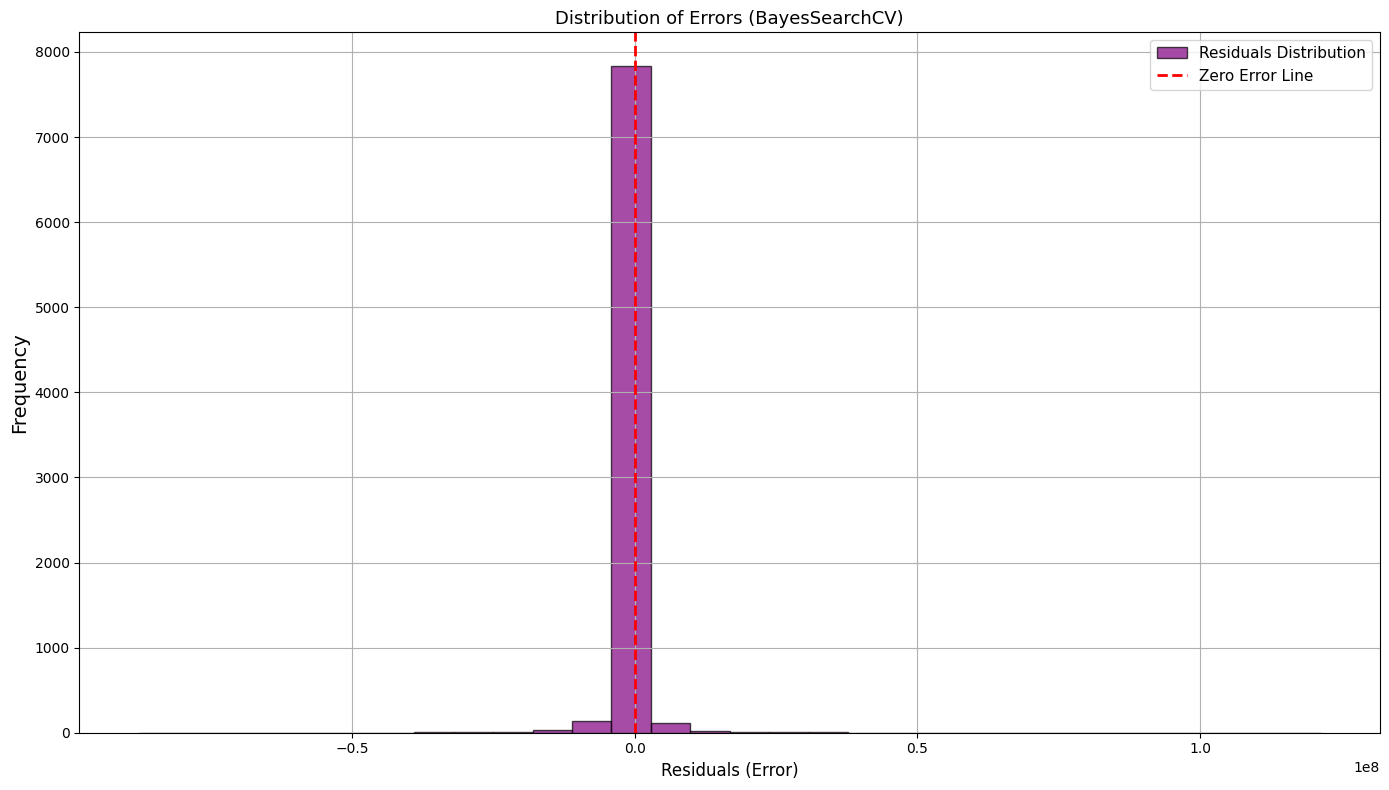

Processing time: 13503.8006 seconds


In [54]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
df = pd.read_csv('USVideos.csv', parse_dates=['publish_time'])

def trainModelWithBayesSearch(X, y, search_spaces, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    svr = SVR()

    bayes_search = BayesSearchCV(
        svr, 
        search_spaces=search_spaces,
        n_iter=30,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)
    best_svr = bayes_search.best_estimator_

    # Predictions on log scale
    y_pred = best_svr.predict(X_test)
    return y_pred, y_test

category_features, text_features, num_features_scaled = featureExtraction(df)

# CHANGE: Replace text_features with text_features_svd
X = np.hstack([text_features.toarray(), category_features, num_features_scaled])
# Target (log-transform views)
y = np.log1p(df['views'].values)

search_spaces = {
    'C': Real(0.1, 10, prior='log-uniform'),  # Regularization parameter
    'epsilon': Real(0.01, 0.5, prior='uniform'),  # Tolerance margin
    'gamma': Categorical(['scale', 'auto']),  # Kernel coefficient
    'kernel': Categorical(['rbf'])
}
start_time = time.time()

y_pred, y_test = trainModelWithBayesSearch(X, y, search_spaces)

end_time = time.time()
elapsed_time = end_time - start_time

evalAndChart(y_pred, y_test, "BayesSearchCV")
print(f"Processing time: {elapsed_time:.4f} seconds")